### Example estimation of ecohydrological parameters from soil moisture observations using PIEP

**For methods description see:**

Bassiouni, M., C.W. Higgins, C.J. Still, and S.P. Good (2018), Probabilistic inference of ecohydrological parameters using observations from point to satellite scales. *Hydrology and Earth System Sciences*, 22(6), pp.3229-3243. https://doi.org/10.5194/hess-22-3229-2018.

**For results from a global application see**: 

Bassiouni, M., S.P. Good, C.J. Still, and C.W. Higgins (2020), Plant water uptake thresholds inferred from satellite soil moisture. *Geophysical Research Letters*. 47(7), e2020GL087077. https://doi.org/10.1029/2020GL087077

Global dataset of ecohydrological parameters inferred from satellite observations (2020) https://doi.org/10.5281/zenodo.3351622

In [10]:
from param_sm_pdf import Processor
from sswm import SM_A
from datetime import datetime
from pickle import load
from os import path
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cumfreq
import sys

np.seterr(divide='ignore', invalid='ignore')
% matplotlib inline

#### List of data to process

Each iterable is a dictionary that includes:
- soil moisture observations
- known parameters of the stochastic soil water balance
- unknown parameters with placeholder values
- optional characteristics to identify the site

Data reference: Dennis Baldocchi  (2001-) AmeriFlux US-Ton Tonzi Ranch, 10.17190/AMF/1245971

In [2]:
data = np.load(path.join('iterables', 'example_input.pickle'))

#### Variables for the MH-MCMC algorithm 

In [6]:
num_pl = 3                          # number of sample threads
samples = 20000                     # number of simulations per thread
max_num_pl = 10                     # max number of total run samples possible
n_pl_min = num_pl                   # min number of converged run samples to provide results
burnin = 1. / 2.                    # Fraction of burn in period
efficiency_lim = [1, 90]            # limits of MH-MCMC acceptable efficiency

#### Estimate $E_{max}$, $s_{wilt}$, $s^*$ (dry period length = 0 days)

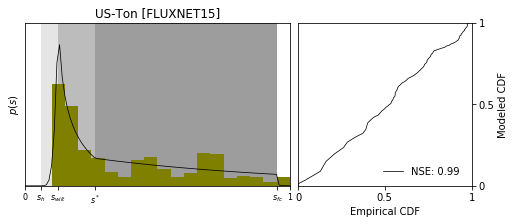

In [7]:
unknown_params_annual = ['et0', 's_wilt','s_star'] # use names consistent with dict.  
mhmcmc = Processor(unknown_params_annual)
loc_res = example_inversion(data[0])
plot_p(loc_res)

#### Estimate $E_{max}$, $E_{max-dry}$, $s_{wilt}$, $s^*$ (dry period length, td = 153 days)

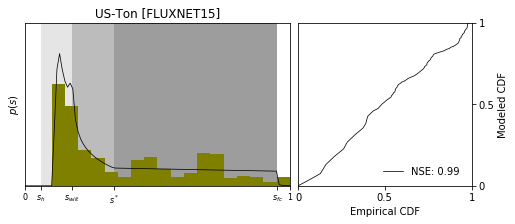

In [9]:
unknown_params_seasonal = ['et0', 'et0_dry', 's_wilt','s_star'] 
mhmcmc = Processor(unknown_params_seasonal)
loc_res = example_inversion(data[1])
plot_p(loc_res)

#### Example model inversion & result plotting functions

In [3]:
def example_inversion(dfi):
    dt0 = datetime.now()
    theta0 = {'s_wilt': dfi['s_wilt'],
              's_star': dfi['s_star'], 
              'delta': dfi['delta'],
              'rf_lambda': dfi['rf_lambda'],
              'rf_alpha': dfi['rf_alpha'],
              'Zr': dfi['Zr'],
              'b': dfi['b'],
              'Ks': dfi['Ks'],
              'n': dfi['n'],
              's_h': dfi['s_h'],
              's_fc': dfi['s_fc'],
              'f_w': dfi['f_w'],
              'f_max': dfi['f_max'],
              'et0': dfi['et0'],
              'et0_dry': dfi['et0_dry'],
              't_d': dfi['t_d']
             }

    p_ranges = {'s_wilt': [dfi['s_h'], dfi['s_fc']], 
                's_star': [dfi['s_h'], dfi['s_fc']],
                'f_w': [0., 0.1],
                'f_max': [0.1, 1],
                'et0': [0, 10],
                'et0_dry': [0, 10],
                'Zr': [20, 600]}
                # add ranges as necessary to optimize for other variables

    pl_results, n_it, fail_conv_count, fail_eff_count = mhmcmc.get_mcmc_mh_results(
                                                            dfi['s_obs'], 
                                                            theta0, p_ranges,
                                                            nbr_sim=samples, 
                                                            num_pl=num_pl,
                                                            burnin=burnin,
                                                            max_num_pl=max_num_pl,
                                                            efficiency_lim=efficiency_lim)
    dfi['n_it'] = n_it
    dfi['num_pl'] = len(pl_results)
    dfi['fail_conv_count'] = fail_conv_count
    dfi['fail_eff_count'] = fail_eff_count

    if dfi['num_pl'] == n_pl_min:
        dfi = mhmcmc.process_raw_results(dfi, pl_results, outfile_format='full')

    dfi['ctime'] = (datetime.now() - dt0).seconds / 60.
    dfi['fail_conv_count'] = fail_conv_count + dfi['fail_conv_count']
    dfi['fail_eff_count'] = fail_eff_count + dfi['fail_eff_count']
    
    return dfi

In [4]:
def plot_p(dfi):
    bins = np.linspace(0, 1, 21)
    s_list = np.linspace(0, 1, 101)
    p_fitted_norm, smpdf = get_p_fitted(dfi)
    p_fitted_norm = p_fitted_norm * 100.
    l_cdf_m = 101
    cdf_m = np.cumsum(p_fitted_norm)
    cdf_m_n = cdf_m / np.max(cdf_m)
    cumfreqs_e, lowlim_e, binsize_e, extrapoints_e = cumfreq(dfi['s_obs'], 
                                                             numbins=l_cdf_m, 
                                                             defaultreallimits=[0, 1])
    cumfreqs_e = np.array(cumfreqs_e) / np.max(cumfreqs_e)

    fig = plt.figure(figsize=(8, 3))
    axp = plt.subplot2grid((1, 5), (0, 0), colspan=3)
    axq = plt.subplot2grid((1, 5), (0, 3), colspan=2)
    
    axp.fill_between([dfi['s_h'], dfi['s_fc']], [0, 0], [7, 7], color='grey', alpha=0.2, lw=0)
    axp.fill_between([dfi['s_wilt'], dfi['s_fc']], [0, 0], [7, 7], color='grey', alpha=0.4, lw=0)
    axp.fill_between([dfi['s_star'], dfi['s_fc']], [0, 0], [7, 7], color='grey', alpha=0.5, lw=0)
    axp.hist(dfi['s_obs'], bins, normed=1, edgecolor='None', facecolor='olive')
    axp.plot(s_list, p_fitted_norm, color='k', lw=0.75)
    axp.set_yticks([])
    axp.set_xticks([0, dfi['s_h'], dfi['s_wilt'], dfi['s_star'], dfi['s_fc'],1])
    axp.set_ylabel(r'$p(s)$')
    axp.set_xticklabels(['0', '$s_{h}$', '$s_{wilt}$', '$s^*$',  '$s_{fc}$', '1'], fontsize=8)
    axp.set_xlabel('')
    axp.set_ylim([0, 7])
    axp.set_xlim([0, 1])
    axp.set_title('%s [%s]' % (dfi['site_name'], dfi['scale']))
    
    axq.plot(cumfreqs_e, cdf_m_n, lw=0.75, color='k', label = 'NSE: %-5.2f' % (dfi['NSE']))
    axq.yaxis.tick_right()
    axq.set_xlim([0, 1])
    axq.set_ylim([0, 1])
    axq.set_xticks([0, 0.5, 1])
    axq.set_xticklabels(['0', 0.5, '1'], fontsize=10)
    axq.set_yticklabels(['0', 0.5, '1'], fontsize=10)
    axq.set_yticks([0, 0.5, 1])
    axq.set_xlabel('Empirical CDF')
    axq.set_ylabel('Modeled CDF')
    axq.yaxis.set_label_position('right')
    plt.legend(frameon=False, loc='lower right')
    
    fig.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

In [5]:
def get_p_fitted(dfi):
    theta_l = [dfi['s_h'], dfi['s_wilt'], dfi['s_star'], dfi['s_fc'],
               dfi['f_max'],  dfi['f_w'],  dfi['et0'], 
               dfi['rf_alpha'], dfi['rf_lambda'], dfi['delta'],
               dfi['b'], dfi['Ks'], dfi['n'], dfi['Zr'],
               dfi['et0_dry'], dfi['t_d']]

    smpdf = SM_A(theta_l)
    p_fitted_norm = smpdf.get_p0()
    return p_fitted_norm, smpdf